In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(22)
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd
import math

In [2]:
# Import
# Imports all csv files in folder and concatonates the data sets from trackmate.

import glob

df = pd.DataFrame()
for filename in glob.glob('data/*.csv'):
    data_01 = pd.read_csv(filename, sep=',')
    filename = filename.split('/')[1]
    filename = filename.split('.')[0]
    well = filename.split('_')[6]
    data_01['Well'] = well.split('-')[0]
    data_01['FOV'] = filename.split('_')[7]
    data = data_01[['Frame','Track_ID', 'Well', 'FOV', 'X', 'Y', 'Channel_2', 'Channel_3']]
    df = df.append(data,  ignore_index=True)
df['Sample_ID'] = df.Well + '-' + df.FOV
df['Sample_ID'] = df.Sample_ID + '-Track-' + df.Track_ID.astype(str)

In [ ]:
# Baseline Subtract
# Subtract baseline using min value: Channel_2.

def subtract_bl(in_df):
    traces = in_df
    traces_p = traces.pivot_table(index='Frame', columns='Sample_ID', values='Channel_2')
    df_test2 = pd.DataFrame()
    for columns in traces_p:
        minvalue = traces_p[columns].min()
        base_sub = lambda x: x-minvalue
        df_test = in_df[in_df['Sample_ID']==columns]
        df_test['bc_channel_1'] = df_test['Channel_2']-minvalue
        df_test2 = df_test2.append(df_test)
    return df_test2
    
df_bl = subtract_bl(df)

In [ ]:
# Baseline Subtract
# Subtract baseline using min value: Channel_3.

def subtract_bl(in_df):
    traces = in_df
    traces_p = traces.pivot_table(index='Frame', columns='Sample_ID', values='Channel_3')
    df_test2 = pd.DataFrame()
    for columns in traces_p:
        minvalue = traces_p[columns].min()
        base_sub = lambda x: x-minvalue
        df_test = in_df[in_df['Sample_ID']==columns]
        df_test['bc_channel_2'] = df_test['Channel_3']-minvalue
        df_test2 = df_test2.append(df_test)
    return df_test2
    
df_bl = subtract_bl(df_bl)

In [3]:
# Save as Pickle
# Save baseline subtracted data to pickle file.

df_bl.to_pickle("baseLine_subtract.pkl")

NameError: name 'df_bl' is not defined

In [5]:
# Import baseline subtracted pickle file into Pandas dataframe.

df_bl = pd.read_pickle("baseLine_subtract.pkl")
df_f=df_bl

In [6]:
# Filter Edges
# Filter out inclusion near the edges of the field of view.

df2 = df_f[~(df_f['X']<10)]
df2 = df2[~(df2['X']>670)]
df2 = df2[~(df2['Y']<10)]
df2 = df2[~(df2['Y']>670)]

In [7]:
# Time-lapse Calibration
# Calibrate Frame values from the image slices to time values of experiment.

totalFrames = 49
startTime = 12
interval = 0.5

frame_dict = {}
for i in range(totalFrames):
    if i == 0:
        frame = i 
        frame_dict[frame] = startTime+1
    else:
        frame = i 
        startTime += interval
        frame_dict[frame] = startTime+1
df2['Time'] = df2['Frame'].map(frame_dict)

In [9]:
# Track Duration Filter
# Filter out traces that do not extend over two time points.

df_f1 = df2['Sample_ID'][df2['Time']==16]
df_f2 = df2['Sample_ID'][df2['Time']==36]
df_f3 = df_f1[df_f1.isin(df_f2)]
df3 = df2[df2['Sample_ID'].isin(df_f3)]

In [10]:
# Assign Treatment
# Assign treatments to wells, Wt = wildtype, Mt = mutant.

Wt    = df3[df3['Well'].str.contains("A1").fillna(False)]
Mt    = df3[df3['Well'].str.contains("A2").fillna(False)|df3['Well'].str.contains("A3").fillna(False)|
                                                         df3['Well'].str.contains("B1").fillna(False)|
                                                         df3['Well'].str.contains("B2").fillna(False)|
                                                         df3['Well'].str.contains("B3").fillna(False)]

In [11]:
# Filter for Growth
# Filter for inclusions that exhibit sufficient growth.

def filterII(in_df, threshold):
    traces_p =       in_df.pivot_table(index='Frame', columns='Sample_ID', values='bc_channel_1')
    df_pass = pd.DataFrame(columns=['Sample_ID', 'pass'])
    for cn in traces_p.columns:
        index_min = traces_p[cn].idxmin(axis=1, skipna=True)
        min_value = traces_p[cn].min()
        traces_p_min = traces_p[traces_p.index>=index_min]
        max_value = traces_p_min[cn].max()
       
        if max_value > threshold*(abs(min_value)+1):
            df_pass = df_pass.append({'Sample_ID':cn, 'pass': True}, ignore_index=True)
            
    new_df = pd.merge(in_df, df_pass,  how='right', on=['Sample_ID'])
    return new_df
     
Wt_f=  filterII(Wt,10000)
Mt_f=  filterII(Mt,10000)

In [12]:
# Pivot dataframe use Time as index and Sample_ID as columns.

def pivot(in_df, channel):
    in_df_p = in_df.pivot_table(index='Time', columns='Sample_ID', values=channel)
    return in_df_p

In [13]:
# Pivot dataframe use Time as index and Sample_ID as columns.

Wt_Euo_p    = pivot(Wt_f,   'bc_channel_1')  
Wt_HctB_p    = pivot(Wt_f,   'bc_channel_2')

Mt_Euo_p    = pivot(Mt_f,   'bc_channel_1')  
Mt_HctB_p    = pivot(Mt_f,   'bc_channel_2')

<IPython.core.display.Javascript object>


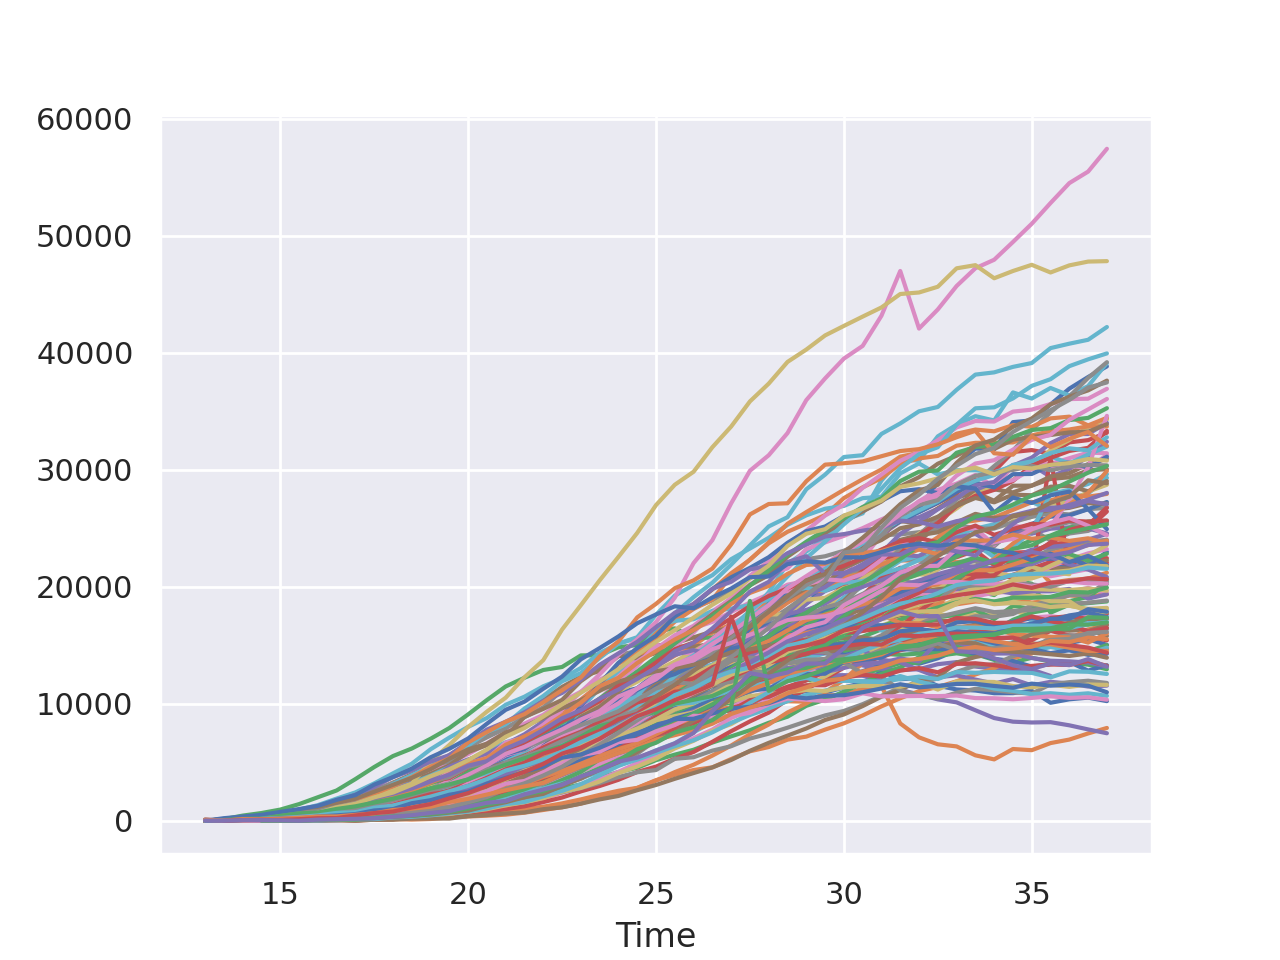

In [14]:
#Check filtering threshold.

Wt_Euo_p.plot(legend=False)

In [ ]:
# Count Inclusion Tracks

Wt_inclusion_number = Wt_Euo_p.shape[1]-2
Mt_inclusion_number = Mt_Euo_p.shape[1]-2
print('Number of Inclusion Tracks =', Wt_inclusion_number + Mt_inclusion_number)

In [ ]:
# Calculate Percent Mortality

mt_tracks = Mt_Euo_p.shape[1]-2
wt_tracks = Wt_Euo_p.shape[1]-2
print('Percent Mortality =' ,100-(mt_tracks/5)/(wt_tracks*3)*100)

In [ ]:
# Calculate
# Calculate max, min, halfmax and time to halfmax.

def halfmax(in_pd):
    in_pd_c1_p = in_pd.pivot_table(index='Sample_ID', columns='Time', values='bc_channel_1')
    in_pd_c1_p['max_c1'] = in_pd_c1_p.max(axis=1)
    in_pd_c2_p = in_pd.pivot_table(index='Sample_ID', columns='Time', values='bc_channel_2')
    in_pd_c2_p['max_c2'] = in_pd_c2_p.max(axis=1)
    in_pd_c1_p['min_c1'] = 1
    in_pd_c2_p['min_c2'] = 1
    in_pd_c1_p['half_max_c1'] = in_pd_c1_p['max_c1']/2
    in_pd_c2_p['half_max_c2'] = in_pd_c2_p['max_c2']/2
    in_pd_f = in_pd_c1_p[['min_c1','max_c1', 'half_max_c1']]
    in_pd_f['min_c2'] = in_pd_c2_p['min_c2']
    in_pd_f['max_c2'] = in_pd_c2_p['max_c2']
    in_pd_f['half_max_c2'] = in_pd_c2_p['half_max_c2']
    in_pd_f.index.name = None
    in_pd_f['Sample_ID'] = in_pd_f.index
    traces = in_pd
    traces_c1_p =       traces.pivot_table(index='Time', columns='Sample_ID', values='bc_channel_1') 
    traces_c1_p_fill =  traces_c1_p.fillna(method='bfill') #back fill to frame 0
    traces_c1_p_fill.reset_index(inplace = True)
    df_c1_f = traces_c1_p_fill
    df_c1_f.set_index(df_c1_f['Time'], inplace=True)
    traces_c2_p =       traces.pivot_table(index='Time', columns='Sample_ID', values='bc_channel_2') 
    traces_c2_p_fill =  traces_c2_p.fillna(method='bfill') #back fill to frame 0
    traces_c2_p_fill.reset_index(inplace = True)
    df_c2_f = traces_c2_p_fill
    df_c2_f.set_index(df_c2_f['Time'], inplace=True)
    time_halfmax_c1 = pd.DataFrame(columns=['Sample_ID', 'time_to_halfmax_c1'])
    time_halfmax_c2 = pd.DataFrame(columns=['Sample_ID', 'time_to_halfmax_c2'])
    for index, row in in_pd_f.iterrows():
        sampleID = row['Sample_ID']
        time_c1 = (df_c1_f[sampleID]-row['half_max_c1']).abs().sort_values().index[0]
        time_c2 = (df_c2_f[sampleID]-row['half_max_c2']).abs().sort_values().index[0]
      
        time_halfmax_c1 = time_halfmax_c1.append({'Sample_ID':sampleID, 'time_to_halfmax_c1': time_c1}, ignore_index=True)
        time_halfmax_c2 = time_halfmax_c2.append({'Sample_ID':sampleID, 'time_to_halfmax_c2': time_c2}, ignore_index=True)
       

    data_summary = pd.merge(time_halfmax_c1, time_halfmax_c2, on='Sample_ID')
    # Add x y coordinates at last time imaged.
    df_time = df3[df3['Time']==35]
    df_time = df_time[['Sample_ID', 'X', 'Y']]
    # Data_summary  only for Sample IDs in both.
    result = pd.merge(data_summary, df_time, how='inner', on=['Sample_ID'])
    return result

Wt_hm = halfmax(Wt_f)
Mt_hm = halfmax(Mt_f)

In [ ]:
# Visualize idividual traces in interactive graph.

from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook, output_file
from bokeh.layouts import row
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label
from bokeh.models import HoverTool
from collections import OrderedDict
from bokeh.layouts import layout
from bokeh.models import Toggle, BoxAnnotation, CustomJS

output_notebook()

c = sns.color_palette('Set1',1000).as_hex()

def interactive_graph(in_df):
    in_df_p = pivot(in_df, 'bc_channel_1')
    df_new = in_df_p[in_df_p.columns[0:-2]]
    result = halfmax(in_df)
    #result = in_df
    
    tools_to_show = 'box_zoom,save,hover,reset'
    p = figure(plot_height = 500, plot_width = 500,
               toolbar_location='above', tools=tools_to_show,
               # "easy" tooltips in Bokeh 0.13.0 or newer
               tooltips=[("Location","$name")])
    j=0
    for i, column in enumerate(df_new):
        trackx = result[result['Sample_ID'] == df_new.iloc[:,i].name].X.values
        tracky = result[result['Sample_ID'] == df_new.iloc[:,i].name].Y.values
        x = str(int(trackx))
        y = str(int(tracky))
        well = df_new.iloc[:,i].name.split('-')[0]
        field = df_new.iloc[:,i].name.split('-')[1]
        well = df_new.iloc[:,i].name
        name = well+', x='+x+', y='+y
        p.line(df_new.index.values, df_new.iloc[:,i].values, name = name, line_color=c[j], line_width=2.5)
        j=j+1
    p.legend.location = "top_left"
    p.legend.click_policy="mute"
    show(p)
interactive_graph(Mt_f)

In [ ]:
# Half-Max Plot
# Visualize time to half-maximal expression of each promoter for individual inclusions.
# Identify location of inclusion outliers.

def spot_plot(title, in_df, in_df2):
    TOOLTIPS = [("ID", "@Sample_ID"), ('X', '@X'), ('Y', '@Y')]
    p = figure(title=title, tooltips=TOOLTIPS, y_range=(29, 38), x_range=(15, 35), plot_width=600, plot_height=300)
    source = ColumnDataSource(in_df)
    source2= ColumnDataSource(in_df2)
    p.circle(x='time_to_halfmax_c1', y='time_to_halfmax_c2', size=10, color='red', alpha=0.25, source=source)
    p.circle(x='time_to_halfmax_c1', y='time_to_halfmax_c2', size=10, color='blue', alpha=0.25, source=source2)
    show(p)
    
spot_plot('EMS', Mt_hm, Wt_hm)

In [ ]:
# Animated Plot
# Visualize promoter expression kientics of each inclusion through time.

Wt_f['treatment']='none'
Mt_f['treatment']='EMS'
df3 = pd.concat([Wt_f, Mt_f])
df3.sort_values('Time', inplace=True)
df3['euoprom']= df3["bc_channel_1"]
df3['hctBprom']= df3["bc_channel_2"]

import plotly.express as px

gapminder = px.data.gapminder()
fig = px.scatter(df3, x='euoprom', y='hctBprom', animation_frame="Time",
           hover_name="Sample_ID", animation_group="Sample_ID", color='treatment',
           log_x=False, size_max=85, range_x=[-500, 55000], range_y=[-100, 9000], color_discrete_map = {"none": 'rgba(0, 0, 255, .3)', "EMS": 'rgba(255, 50, 50, .3)'})
fig.update_traces(marker=dict(size=10))
fig.show()

In [ ]:
# Inclusion Locator
# Visualize euo vs hctB expression at 32 HPI for individual inclusions.
# Identify location of inclusion outliers.

Mt28 = Mt_f[Mt_f['Time']==28] # Get values at specified HPI for all sample IDs.
Wt28 = Wt_f[Wt_f['Time']==28] # Get values at specified HPI for all sample IDs.
def spot_plot(title, in_df, in_df2):
    TOOLTIPS = [("ID", "@Sample_ID"), ('X', '@X'), ('Y', '@Y')]
    p = figure(title=title, tooltips=TOOLTIPS, x_range=(0, 45000), y_range=(-100, 1000), plot_width=600, plot_height=300)
    source = ColumnDataSource(in_df)
    source2= ColumnDataSource(in_df2)
    p.circle(x='bc_channel_1', y='bc_channel_2', size=10, color='red', alpha=0.25, source=source)
    p.circle(x='bc_channel_1', y='bc_channel_2', size=10, color='blue', alpha=0.25, source=source2)
    show(p)
    
spot_plot('EUO vs HctB @28 HPI', Mt28, Wt28)